In [1]:
import datetime as dt
import os
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from deep_hvac import agent, ppo, runner, simulator, util
import importlib
importlib.reload(ppo)
importlib.reload(runner)
importlib.reload(simulator)
importlib.reload(util)



/home/oski/.virtualenvs/6484-proj/lib/python3.8/site-packages/torch/utils/tensorboard/__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, '__version__') or LooseVersion(tensorboard.__version__) < LooseVersion('1.15'):
/home/oski/.virtualenvs/6484-proj/lib/python3.8/site-packages/easyrl/envs/shmem_vec_env.py:23: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.bool: ctypes.c_bool}


<module 'deep_hvac.util' from '/home/oski/github/6-484-proj/deep_hvac/util.py'>

In [2]:
expert = pd.read_pickle('../data/results-expert-medium-summer.pickle')
expert_frame = util.load_expert_performance(expert)

env, env_name = runner.make_default_env(
    discrete_action=True, expert_performance=expert['expert_performance'],
    season='summer', capacitance='medium')

2022-05-05 08:29:48,069 - deep_hvac - DEBUG - Creating environment DefaultBuilding-medium-action-discrete-summer-discomf-terminate-True-v0.
2022-05-05 08:29:48,070 - deep_hvac - DEBUG - Loading NSRDB data from /home/oski/github/6-484-proj/deep_hvac/../data/1704559_29.72_-95.35_2018.csv
2022-05-05 08:29:48,379 - deep_hvac - DEBUG - Loading Houston price data from /home/oski/github/6-484-proj/deep_hvac/../data/houston-2018-prices.pickle


[INFO][2022-05-05 08:29:48]: Creating 1 environments.
/home/oski/.virtualenvs/6484-proj/lib/python3.8/site-packages/gym/core.py:172: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed) instead.
  deprecation(
/home/oski/.virtualenvs/6484-proj/lib/python3.8/site-packages/easyrl/envs/dummy_vec_env.py:34: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.buf_dones = np.zeros((self.num_envs,), dtype=np.bool)


In [3]:
ppo_agents = {}
ppo_bc_agents = {}

ppo_agents_results = {}
ppo_bc_agents_results = {}

for modeldir in os.listdir('../data'):
    if env_name not in modeldir:
        continue
    if 'bc-ppo' in modeldir and '-100000-' not in modeldir:
        continue
    elif 'bc-ppo' in modeldir:
        modelstore = ppo_bc_agents
    else:
        modelstore = ppo_agents
    for seed in os.listdir(os.path.join(
            '../data', modeldir)):
        if 'bc-ppo' in modeldir:
            model_file = 'ckpt_000000064800.pt'
        else:
            model_file = 'model_best.pt'
        try:
            modelstore[seed] = ppo.load_agent(
                os.path.join(
                    '../data', modeldir, seed, 'model',
                    model_file
                ), env_name
            )[0]
        except ValueError:
            modelstore[seed] = ppo.load_agent(
                os.path.join(
                    '../data', modeldir, seed, 'model',
                    'model_best.pt'
                ), env_name
            )[0]
        
        
        

[INFO][2022-05-05 08:29:48]: Creating 1 environments.
[INFO][2022-05-05 08:29:48]: Alogrithm type:<class 'easyrl.configs.ppo_config.PPOConfig'>
[INFO][2022-05-05 08:29:48]: Loading model from ../data/DefaultBuilding-medium-action-discrete-summer-discomf-terminate-True-v0/seed_2/model/model_best.pt
[INFO][2022-05-05 08:29:48]: Creating 1 environments.
[INFO][2022-05-05 08:29:48]: Alogrithm type:<class 'easyrl.configs.ppo_config.PPOConfig'>
[INFO][2022-05-05 08:29:48]: Loading model from ../data/DefaultBuilding-medium-action-discrete-summer-discomf-terminate-True-v0/seed_1/model/model_best.pt
[INFO][2022-05-05 08:29:48]: Creating 1 environments.
[INFO][2022-05-05 08:29:48]: Alogrithm type:<class 'easyrl.configs.ppo_config.PPOConfig'>
[INFO][2022-05-05 08:29:48]: Loading model from ../data/DefaultBuilding-medium-action-discrete-summer-discomf-terminate-True-v0/seed_0/model/model_best.pt
[INFO][2022-05-05 08:29:48]: Creating 1 environments.
[INFO][2022-05-05 08:29:48]: Alogrithm type:<clas

In [4]:
def results_to_dataframes(results_dict):
    out = {}
    for k, v in results_dict.items():
        if k == 'timestamp':
            continue
        out[k] = pd.DataFrame(
            np.array(v).T,
            index=results_dict['timestamp'][0]
        )

    return pd.concat(out.values(), axis=1, keys=out.keys())


def comfort_violations(frame):
    """Return dataframe with comfort penalty scores."""
    frame = frame.copy()
    frame['occupied'] =  [
        simulator.is_occupied(ts) for ts in frame.index
    ]
    if isinstance(frame.columns, pd.MultiIndex):
        for episode in frame['t_outside'].columns:
            frame[('comfort_penalty', episode)] = frame.apply(
                lambda row: (simulator.comfort_penalty(
                    row['t_outside'][episode],
                    row['t_inside'][episode]) * row['occupied'][0]),
                axis=1
            )
            frame[('comfort violation severe', episode)] = (
                frame[('comfort_penalty', episode)] >= 1
            )
            frame[('comfort violation moderate', episode)] = (
                (frame[('comfort_penalty', episode)] < 1) &
                (frame[('comfort_penalty', episode)] >= 0.5)
            )
    else:
        frame['comfort_penalty'] = frame.apply(
            lambda row: simulator.comfort_penalty(
                row['t_outside'], row['t_inside']
            ) * row['occupied'], axis=1
        )
        frame['comfort violation severe'] = (
            frame['comfort_penalty'] >= 1
        )
        frame['comfort violation moderate'] = (
            (frame['comfort_penalty'] < 1) &
            (frame['comfort_penalty'] >= 0.5)
        )

    return frame

In [5]:
jan1 = dt.datetime(2018, 1, 1, 0, 0)
ppo_results = {}
ppo_bc_results = {}
monthly_results_comfort_agent = {}

n_runs = 5

for month in (8,):
    ppo_results[month] = {}
    ppo_bc_results[month] = {}
    start = dt.datetime(2018, month, 1, 0, 0)
    start_int = int((start - jan1).total_seconds() / 3600)
    for seed in ppo_agents.keys():
        ppoagent = ppo_agents[seed]
        ppobcagent = ppo_bc_agents[seed]
        results_ppo = runner.get_results(
            ppoagent, env, time=start_int, max_steps=24*30*n_runs)
        results_ppobc = runner.get_results(
            ppobcagent, env, time=start_int, max_steps=24*30*n_runs
        )
        ppo_results[month][seed] = results_to_dataframes(results_ppo)
        ppo_bc_results[month][seed] = results_to_dataframes(results_ppobc)
    
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        monthly_results_comfort_agent[month] = \
            results_to_dataframes(
                runner.get_results(
                    agent.AshraeComfortAgent(env=env),
                    env, time=start_int, max_steps=24*30
                )
            )
    


In [6]:
ppo_results_frame = pd.concat(
    {month: pd.concat(v.values(), axis=1, keys=v.keys())
     for month, v in ppo_results.items()}.values(),
    axis=0
).swaplevel(-3, -2, axis=1)
ppobc_results_frame = pd.concat(
    {month: pd.concat(v.values(), axis=1, keys=v.keys())
     for month, v in ppo_bc_results.items()}.values(),
    axis=0
).swaplevel(-3, -2, axis=1)
ppo_results_frame.columns.names = ['field', 'seed', 'trial']
ppobc_results_frame.columns.names = ['field', 'seed', 'trial']

In [7]:
ppo_results_frame.to_pickle('ppo_results_frame.pickle')
ppobc_results_frame.to_pickle('ppobc_results_frame.pickle')

In [8]:
import itertools
def unpivot(frame, start=None, end=None):
    frame = frame.copy()
    frame = frame.swaplevel(-3, -1, axis=1)
    trials = frame.columns.get_level_values(0).unique()
    seeds = frame.columns.get_level_values(1).unique()
    to_concat = []
    for trial, seed in itertools.product(trials, seeds):
        subframe = frame[(trial, seed)].reset_index()
        subframe['trial'] = trial
        subframe['seed'] = seed
        to_concat.append(subframe)
    return pd.concat(to_concat)
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

ppo_results_long = unpivot(ppo_results_frame)
ppobc_results_long = unpivot(ppobc_results_frame)

ppo_results_long = comfort_violations(ppo_results_long.set_index('index')).reset_index()
ppobc_results_long = comfort_violations(ppobc_results_long.set_index('index')).reset_index()

ppo_results_long = ppo_results_long.query("seed == 'seed_1'").set_index('index')
ppobc_results_long = ppobc_results_long.query("seed == 'seed_2'").set_index('index')

/home/oski/.virtualenvs/6484-proj/lib/python3.8/site-packages/seaborn/rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/home/oski/.virtualenvs/6484-proj/lib/python3.8/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


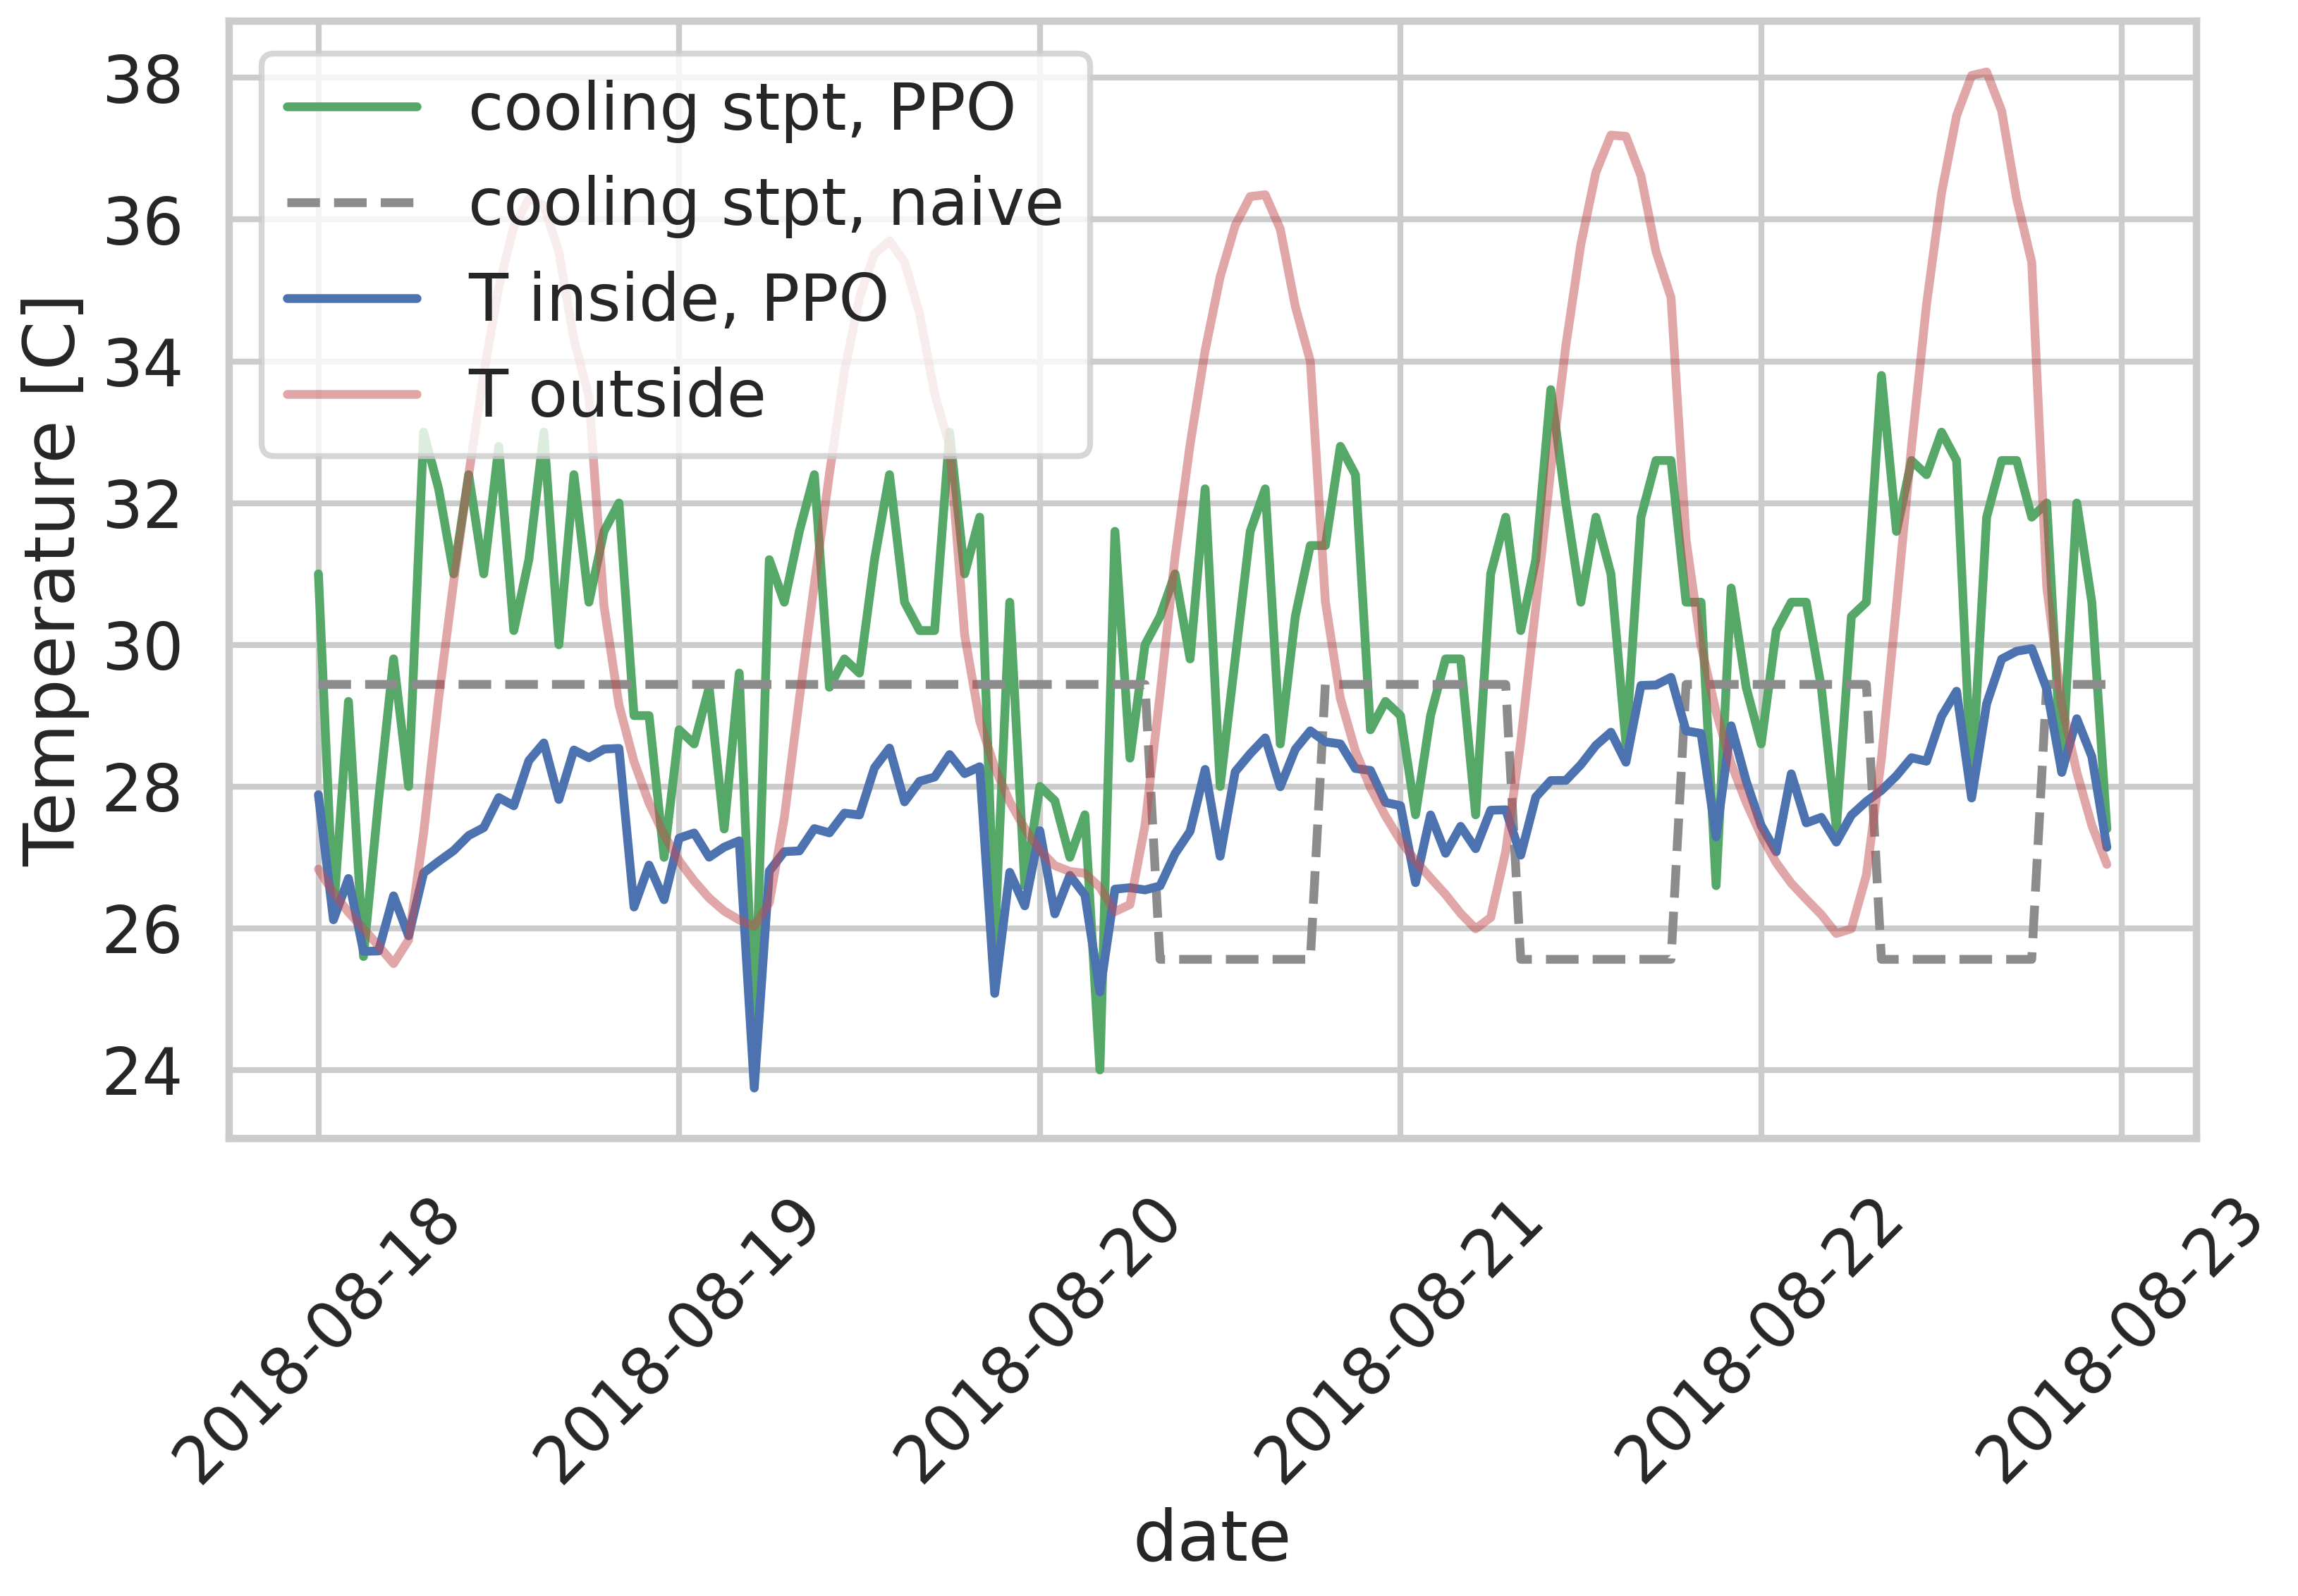

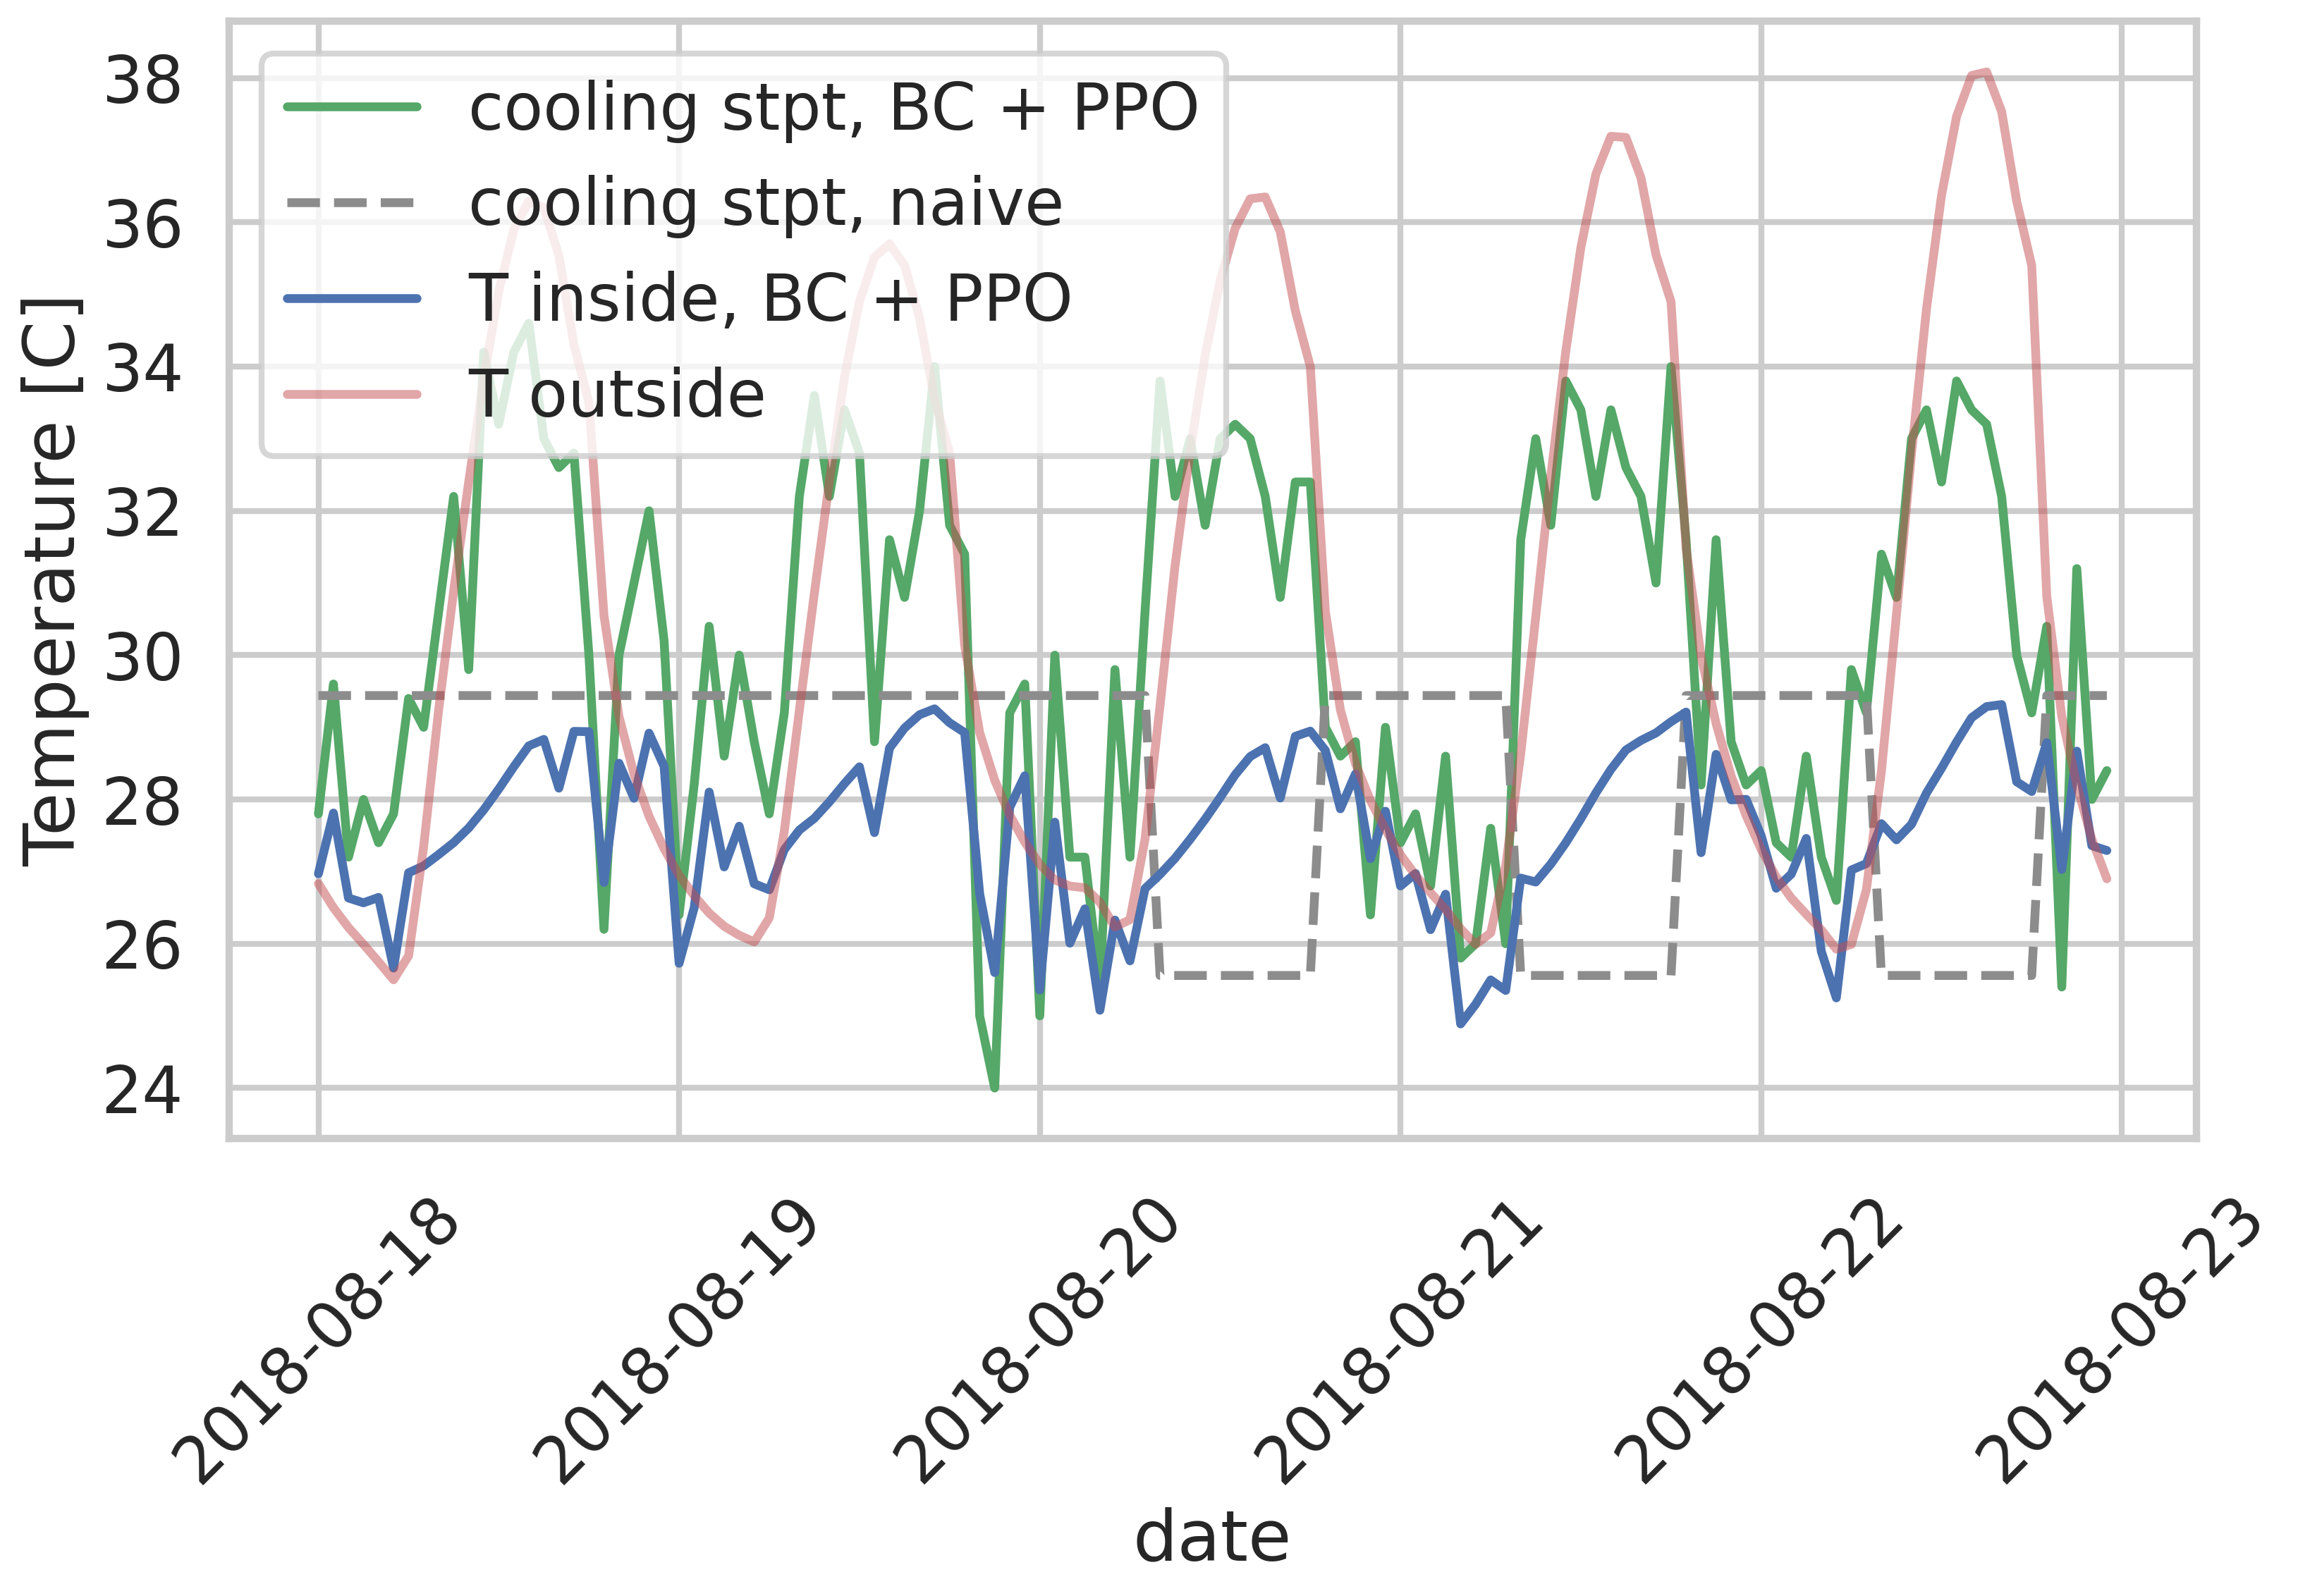

In [12]:
import seaborn as sns
sns.set('poster')
sns.set_style('whitegrid')
start = '2018-08-18'
end = '2018-08-22'
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300


blue = sns.color_palette()[0]
green = sns.color_palette()[2]
red = sns.color_palette()[3]
grey = sns.color_palette()[7]
aqua = sns.color_palette()[9]

expert_subset = expert_frame.loc[start:end]


def temperature_plot(rl_results, expert, start, end, modeltype='PPO'):
    expert_subset = expert.loc[start:end]
    plt.figure(figsize=(12, 7))
    ax = plt.gca()
    sns.lineplot(data=rl_results.loc[start:end].reset_index(),
                 x='index', y='set_cooling', color=green,
                 ci=None,
                 label=f'cooling stpt, {modeltype}',
                 ax=ax)
    ax.plot(expert_subset.index, expert_subset['set_cooling'],
             color=grey, linestyle='dashed',
             label='cooling stpt, naive')
    sns.lineplot(data=rl_results.loc[start:end].reset_index(),
                 x='index', y='t_inside', color=blue, ci=None,
                 label=f'T inside, {modeltype}', ax=ax)
    ax.plot(expert_subset.index, expert_subset['t_outside'],
             color=red, label='T outside', alpha=0.5)
    plt.legend()
    plt.xticks(rotation=45)
    plt.xlabel('date')
    plt.ylabel('Temperature [C]')

temperature_plot(ppo_results_long, expert_frame, start, end,
                 'PPO')
temperature_plot(ppobc_results_long, expert_frame, start, end,
                 'BC + PPO')

In [13]:
def compare_cumsum(rl_result, expert, field, label, start, end, model,
                   color=None):
    rl_result = rl_result.loc[start:end].reset_index().pivot(
        index='index', columns='trial'
    )
    n_trials = rl_result[field].values.shape[1]
    expert = expert.loc[rl_result.index[0]:rl_result.index[-1]]
    plt.plot(expert.index, expert[field].cumsum(),
             label='naive agent', color=grey)
    plt.plot(rl_result.index, rl_result[field].cumsum().values,
             alpha=0.7, color=color or sns.color_palette()[1],
             label=[model] + ['_'] * (n_trials - 1))
    plt.legend()
    plt.xticks(rotation=45)
    plt.ylabel(label)

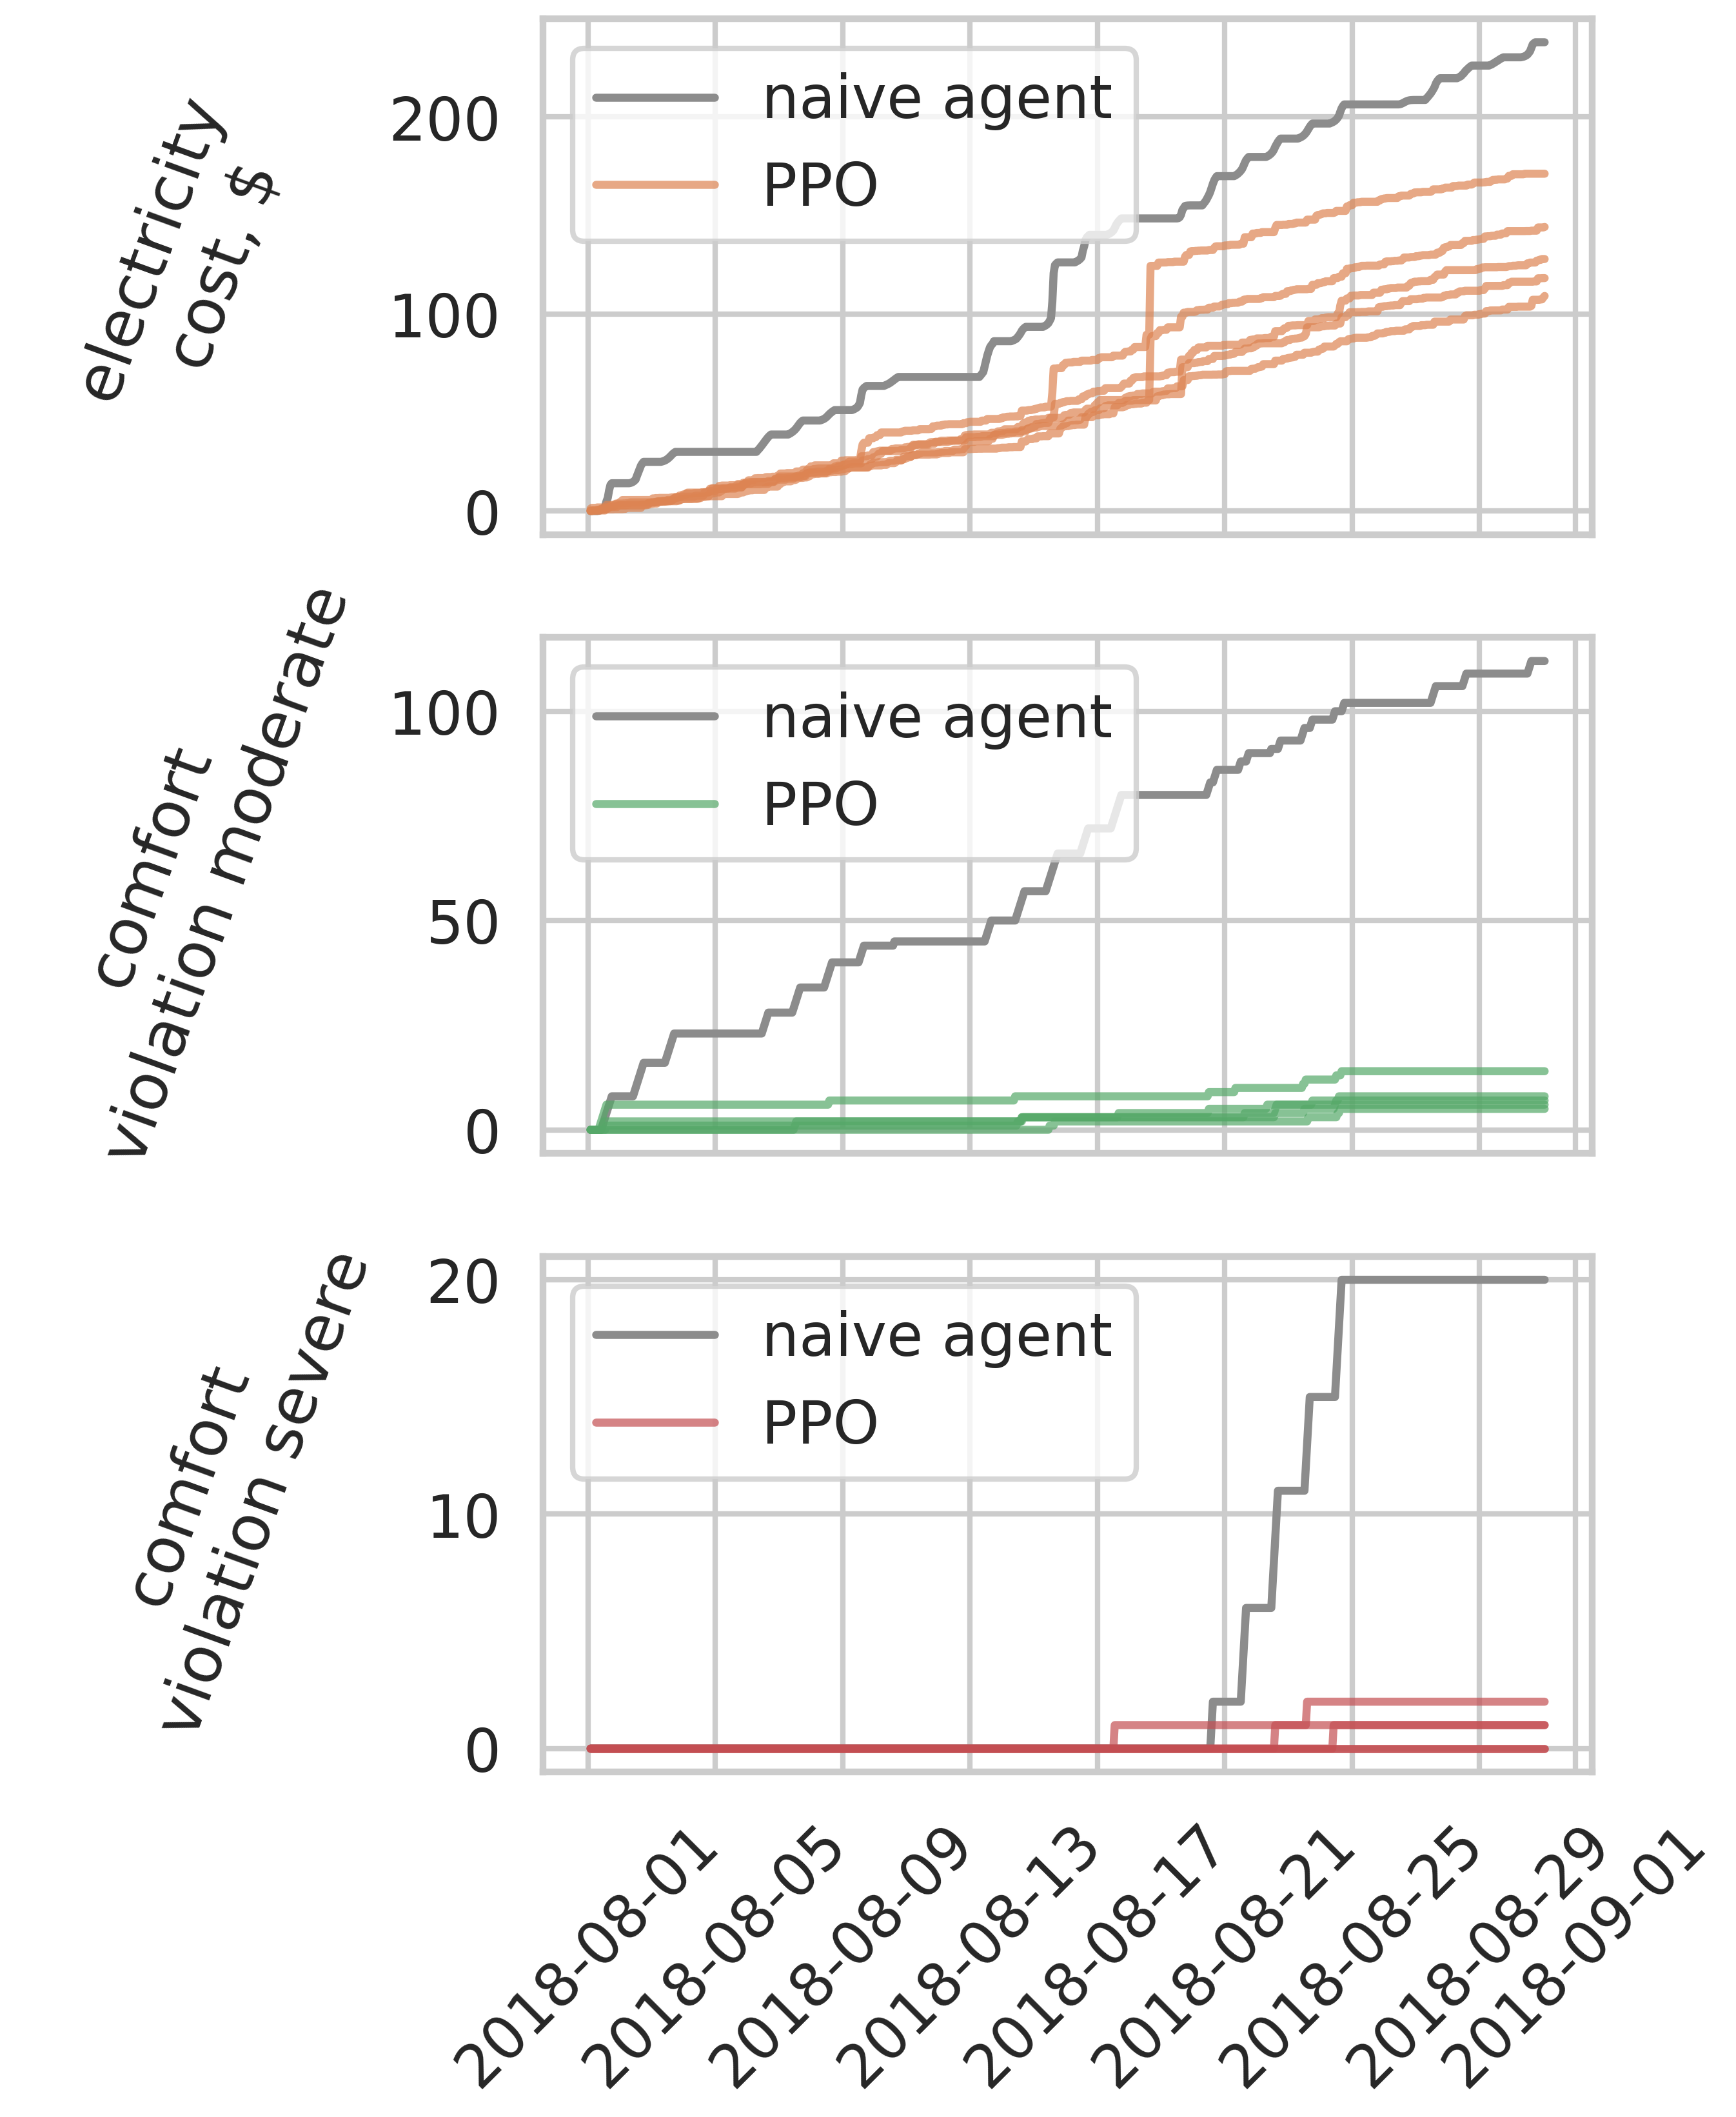

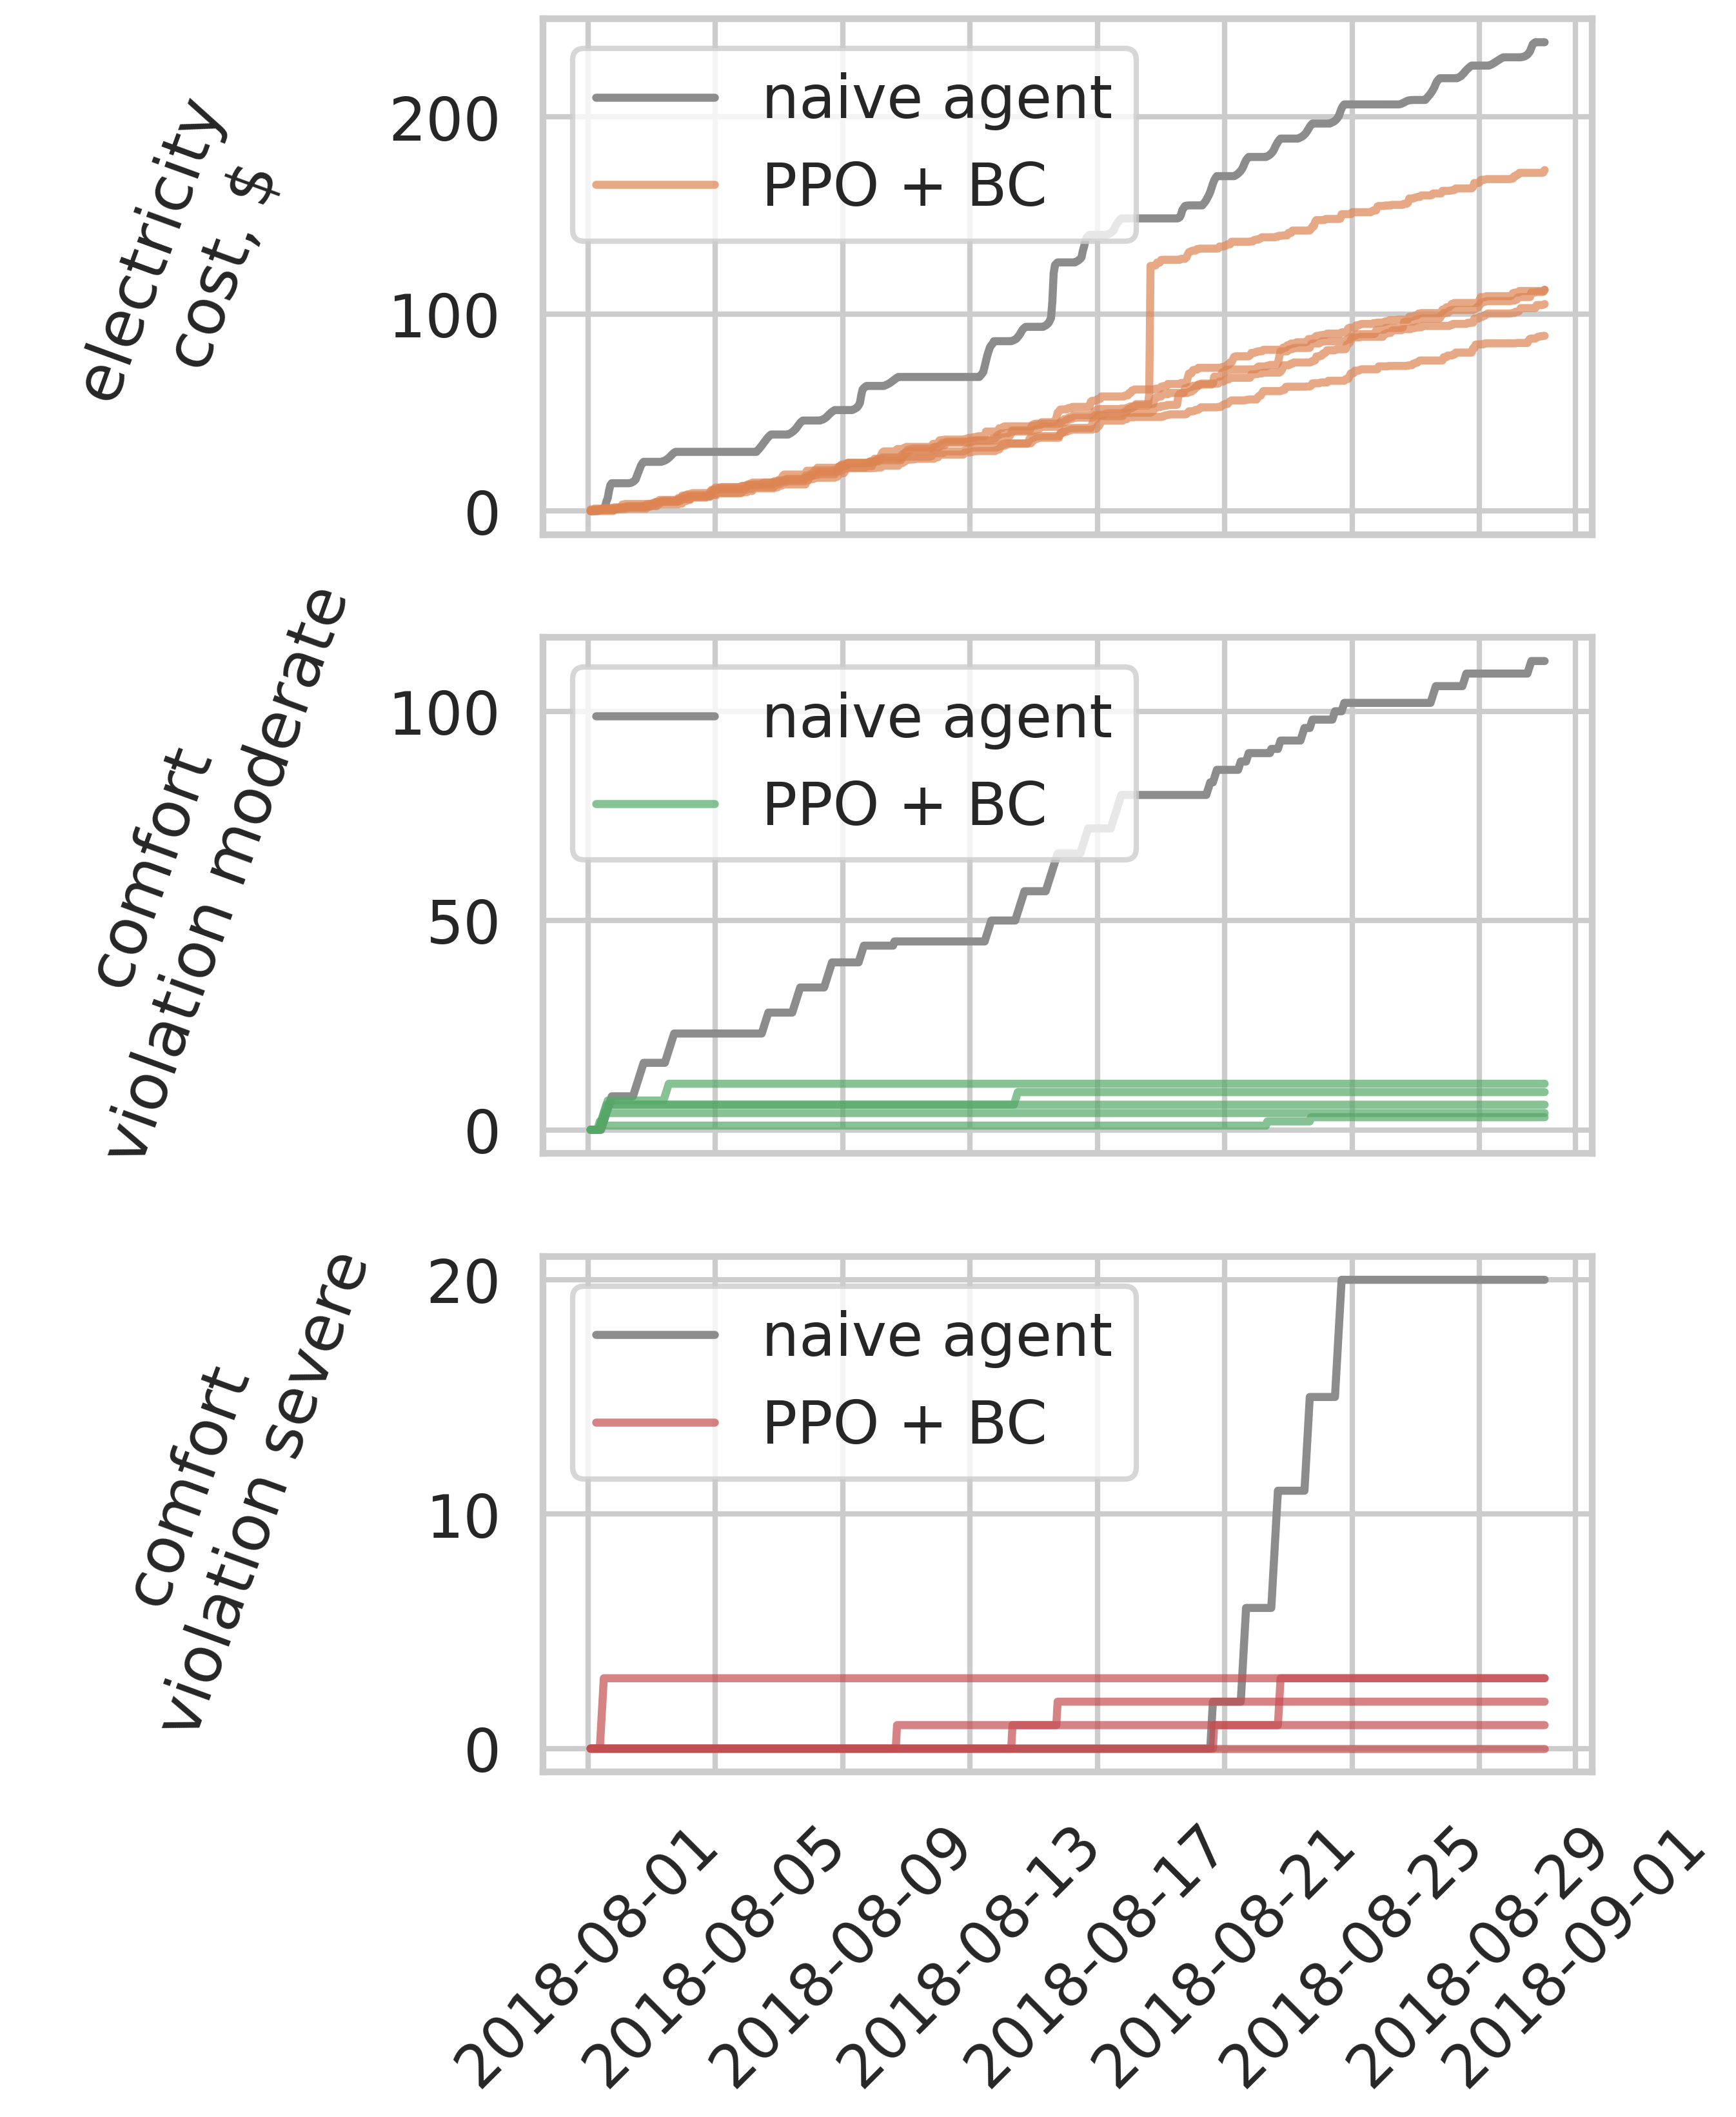

In [14]:
def compare_cumsum_subplots(rl_result, expert, fields, labels,
                            start, end, model):
    n_fields = len(fields)
    fig, axs = plt.subplots(n_fields, figsize=(7, 4 * n_fields),
                            sharex=True)
    for i, (ax, field, label) in enumerate(zip(axs, fields, labels)):
        plt.sca(ax)
        compare_cumsum(rl_result, expert, field, label, start,
                       end, model, color=sns.color_palette()[i+1])
        plt.gca().set_ylabel(label, rotation=70, labelpad=50)
        
expert_frame = comfort_violations(expert_frame)

compare_cumsum_subplots(
    ppo_results_long, expert_frame,
    ['electricity_cost', 'comfort violation moderate',
     'comfort violation severe'],
    ['electricity \ncost, $', 'comfort \n violation moderate',
     'comfort \n violation severe'],
    None, None, 'PPO')

compare_cumsum_subplots(
    ppobc_results_long, expert_frame,
    ['electricity_cost', 'comfort violation moderate',
     'comfort violation severe'],
    ['electricity \ncost, $', 'comfort \n violation moderate',
     'comfort \n violation severe'],
    None, None, 'PPO + BC')